**Мастерская. Проект Dota 2: игровая аналитика. **

**Цель**:  узнать какие факторы влияют на победу в матчах и представить заказчику информацию,будет ему полезна.

**План работы:**


1.   Загрузка данных
2.   Подготовка данных
3.   Исследовательский анализ данных:
- проверить есть ли корреляция между числовыми параметрами (опыт, золото, количество убийств и так далее) и победой в матче;

- построить гистограммы основных параметров матчей (убийства, ассисты, урон в минуту и прочие) в разрезе победивших и проигравших команд и сделать выводы;

- какой герой фармит больше всего золота: по всем матчам, есть ли разница в количестве золота нафармленного героем в разрезе победа / поражение;

- какие герои получают больше всего опыта за игру;

- какие фракции чаще побеждают: свет или тьма;

- сколько в среднем длится победный матч для каждой фракции;

- каких героев чаще всего выбирают;

- какие герои чаще всего выигрывают;

- какие герои совершают больше всего убийств, ассистов;

- какой герой меньше всего умирает;

- сколько в среднем длится матч;

- среднее время до первой крови + гистограмма;

4.   Аналитическая часть:
        - Самое частое время победы одной стороны отличается от самого частого времени победы другой стороны?
        - Помогает ли первая кровь победить?
5.   Итоговые выводы


# Загрузка данных

In [ ]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import pointbiserialr
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
# Параметры подключения к базе данных
db_host = '**********'
db_port = '5432'
db_name = '*******'
db_user = '********'
db_password = '*********'

# Создание строки подключения
connection_string = f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'

# Создание подключения с использованием SQLAlchemy
engine = create_engine(connection_string)

# Выполнение SQL-запроса и загрузка результата в DataFrame
query = 'SELECT Match_id, Duration, First_blood_time, Radiant_win FROM matches'
query1 = 'SELECT Match_id, Personaname, Win, Kills, Assists, Deaths, Hero_id, Hero_damage_per_min, Gold_per_min, Xp_per_min, Kills_per_min, Last_hits_per_min, Denies FROM players'
query2 = 'SELECT Id, Localized_name FROM heroes'
matches = pd.read_sql(query, engine)
players = pd.read_sql(query1, engine)
heroes = pd.read_sql(query2, engine)
# Закрытие соединения
engine.dispose()

# Проверка
print(matches.head())

     match_id  duration  first_blood_time  radiant_win
0  7723956234      1843                 0         True
1  7723925265      1782                74        False
2  7723923401      2054                71        False
3  7723905806      2066                40        False
4  7723895005      1804               169        False


In [ ]:
print(players.head())

     match_id personaname  win  kills  assists  deaths  hero_id  \
0  7723956234     Snémaât    1      6       10       3      123   
1  7723956234       BeNnS    1      9        4       2       86   
2  7723956234      Flint-    1      4       10       8       52   
3  7723956234    shogeyuu    1      5        9       3       51   
4  7723956234      sonlin    1      5       12       6       88   

   hero_damage_per_min  gold_per_min  xp_per_min  kills_per_min  \
0           585.545307           615         696       0.195334   
1           622.333152           532         611       0.293001   
2           478.567553           551         608       0.130222   
3           313.640803           383         463       0.162778   
4           521.345632           336         417       0.162778   

   last_hits_per_min  denies  
0           9.050461       7  
1           6.348345       7  
2           7.357569       2  
3           3.516007       8  
4           2.278893       3  


In [ ]:
print(heroes.head())

    id localized_name
0  123       Hoodwink
1   86         Rubick
2   52        Leshrac
3   51      Clockwerk
4   88   Nyx Assassin


# Подготовка данных

Посмотрим на данные

In [ ]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18020 entries, 0 to 18019
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   match_id             18020 non-null  int64  
 1   personaname          17896 non-null  object 
 2   win                  18020 non-null  int64  
 3   kills                18020 non-null  int64  
 4   assists              18020 non-null  int64  
 5   deaths               18020 non-null  int64  
 6   hero_id              18020 non-null  int64  
 7   hero_damage_per_min  18020 non-null  float64
 8   gold_per_min         18020 non-null  int64  
 9   xp_per_min           18020 non-null  int64  
 10  kills_per_min        18020 non-null  float64
 11  last_hits_per_min    18020 non-null  float64
 12  denies               18020 non-null  int64  
dtypes: float64(3), int64(9), object(1)
memory usage: 1.8+ MB


In [ ]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1802 entries, 0 to 1801
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   match_id          1802 non-null   int64
 1   duration          1802 non-null   int64
 2   first_blood_time  1802 non-null   int64
 3   radiant_win       1802 non-null   bool 
dtypes: bool(1), int64(3)
memory usage: 44.1 KB


In [ ]:
heroes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18020 entries, 0 to 18019
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              18020 non-null  int64 
 1   localized_name  18020 non-null  object
dtypes: int64(1), object(1)
memory usage: 281.7+ KB


Сначала переименум столбец id в hero_id для последующего объединения и переименуем localized_name в hero для удобства


In [ ]:
heroes = heroes.rename(columns={'id': 'hero_id', 'localized_name': 'hero'})

Объединим все данные в одну таблицу

In [ ]:
# Объединение matches и players по столбцу match_id
mp = pd.merge(matches, players, on='match_id')

# Объединение получившейся таблицы с heroes по столбцу id
df = pd.merge(mp, heroes, on='hero_id')

df= df.drop_duplicates()
df

,match_id,duration,first_blood_time,radiant_win,personaname,win,kills,assists,deaths,hero_id,hero_damage_per_min,gold_per_min,xp_per_min,kills_per_min,last_hits_per_min,denies,hero
0,7723956234,1843,0,True,Snémaât,1,6,10,3,123,585.545307,615,696,0.195334,9.050461,7,Hoodwink
368,7723905806,2066,40,False,Snémaât,1,27,18,8,123,1765.963214,805,1220,0.784124,5.866409,12,Hoodwink
736,7723863928,1922,10,False,4lenomandradoto,0,3,11,10,123,361.311134,281,394,0.093652,2.122789,2,Hoodwink
1104,7723808402,1548,271,False,saykeN,1,6,7,7,123,400.116279,544,714,0.232558,5.426357,10,Hoodwink
1472,7723799474,2102,43,True,theconstant,0,5,13,8,123,594.747859,384,554,0.142721,3.368221,5,Hoodwink
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995976,7681138656,2232,276,True,Keyleth,0,7,10,9,75,598.682796,468,487,0.188172,5.430108,22,Silencer
3996010,7680701451,2455,145,False,Sandy,0,4,20,13,75,292.545825,253,380,0.097760,0.684318,2,Silencer
3996044,7680611298,2145,131,True,None,0,4,12,16,75,359.020979,243,321,0.111888,0.699301,1,Silencer
3996078,7679039165,1905,235,False,ShinraTensei,1,1,18,7,75,273.952756,345,558,0.031496,1.543307,0,Silencer


Конвертируем duration и first_blood_time из секунд в минуты

In [ ]:
df['duration'] = df.duration / 60
df['first_blood_time'] = df.first_blood_time / 60

In [ ]:
df.head()

,match_id,duration,first_blood_time,radiant_win,personaname,win,kills,assists,deaths,hero_id,hero_damage_per_min,gold_per_min,xp_per_min,kills_per_min,last_hits_per_min,denies,hero
0,7723956234,30.716667,0.000000,True,Snémaât,1,6,10,3,123,585.545307,615,696,0.195334,9.050461,7,Hoodwink
368,7723905806,34.433333,0.666667,False,Snémaât,1,27,18,8,123,1765.963214,805,1220,0.784124,5.866409,12,Hoodwink
736,7723863928,32.033333,0.166667,False,4lenomandradoto,0,3,11,10,123,361.311134,281,394,0.093652,2.122789,2,Hoodwink
1104,7723808402,25.800000,4.516667,False,saykeN,1,6,7,7,123,400.116279,544,714,0.232558,5.426357,10,Hoodwink
1472,7723799474,35.033333,0.716667,True,theconstant,0,5,13,8,123,594.747859,384,554,0.142721,3.368221,5,Hoodwink


Переименуем столбец radiant_win в win и его значения чтобы понимать какая фракция победила

In [ ]:
df = df.rename(columns={'radiant_win': 'r_win'})
df['r_win'] = df['r_win'].replace(False, 0)
df['r_win'] = df['r_win'].replace(True, 1)

Посмотрим на самые длинные и короткие матчи


In [ ]:
min_time_dur = df['duration'].min()
max_time_dur = df['duration'].max()


print(f"Минимальная продолжительность матча: {min_time_dur:.2f}")
print(f"Минимальная продолжительность матча: {max_time_dur:.2f}")

Минимальная продолжительность матча: 7.32
Минимальная продолжительность матча: 78.83


Проверим на дубликаты

In [ ]:
duplicates = df.duplicated().sum()
duplicates

0

In [ ]:
df.isna().sum()

,0
match_id,0
duration,0
first_blood_time,0
r_win,0
personaname,124
win,0
kills,0
assists,0
deaths,0
hero_id,0


Дубликаты в personaname оставляем без изменений, т.к один игрок может сыграть больше одного матча в нашем датасете

In [ ]:
df.head()

,match_id,duration,first_blood_time,r_win,personaname,win,kills,assists,deaths,hero_id,hero_damage_per_min,gold_per_min,xp_per_min,kills_per_min,last_hits_per_min,denies,hero
0,7723956234,30.716667,0.000000,1,Snémaât,1,6,10,3,123,585.545307,615,696,0.195334,9.050461,7,Hoodwink
368,7723905806,34.433333,0.666667,0,Snémaât,1,27,18,8,123,1765.963214,805,1220,0.784124,5.866409,12,Hoodwink
736,7723863928,32.033333,0.166667,0,4lenomandradoto,0,3,11,10,123,361.311134,281,394,0.093652,2.122789,2,Hoodwink
1104,7723808402,25.800000,4.516667,0,saykeN,1,6,7,7,123,400.116279,544,714,0.232558,5.426357,10,Hoodwink
1472,7723799474,35.033333,0.716667,1,theconstant,0,5,13,8,123,594.747859,384,554,0.142721,3.368221,5,Hoodwink


# Исследовательский анализ данных

## Проверить есть ли корреляция между числовыми параметрами (опыт, золото, количество убийств и так далее) и победой в матче;

In [ ]:
#создание отдельного датафрейма
df_corr = df[['duration', 'win', 'kills', 'assists', 'deaths', 'hero_damage_per_min', 'gold_per_min', 'xp_per_min', 'kills_per_min', 'last_hits_per_min', 'denies','r_win']]
df_corr.head()

,duration,win,kills,assists,deaths,hero_damage_per_min,gold_per_min,xp_per_min,kills_per_min,last_hits_per_min,denies,r_win
0,30.716667,1,6,10,3,585.545307,615,696,0.195334,9.050461,7,1
368,34.433333,1,27,18,8,1765.963214,805,1220,0.784124,5.866409,12,0
736,32.033333,0,3,11,10,361.311134,281,394,0.093652,2.122789,2,0
1104,25.800000,1,6,7,7,400.116279,544,714,0.232558,5.426357,10,0
1472,35.033333,0,5,13,8,594.747859,384,554,0.142721,3.368221,5,1


                         duration           win     kills   assists    deaths  \
duration             1.000000e+00  5.375328e-17  0.183746  0.409208  0.238539   
win                  5.375328e-17  1.000000e+00  0.329204  0.483028 -0.424402   
kills                1.837460e-01  3.292039e-01  1.000000  0.151670 -0.244512   
assists              4.092078e-01  4.830283e-01  0.151670  1.000000  0.108034   
deaths               2.385386e-01 -4.244020e-01 -0.244512  0.108034  1.000000   
hero_damage_per_min  1.312898e-01  2.136281e-01  0.769975  0.144285 -0.190701   
gold_per_min         1.808889e-01  3.385118e-01  0.701092 -0.004687 -0.472358   
xp_per_min           3.229188e-01  3.820276e-01  0.697491  0.180249 -0.374095   
kills_per_min       -1.412173e-01  3.538731e-01  0.911985  0.042841 -0.332774   
last_hits_per_min    1.135070e-01  5.667192e-02  0.391099 -0.304600 -0.452754   
denies               1.326556e-01  5.602437e-02  0.252837 -0.085150 -0.218684   
r_win               -3.48452

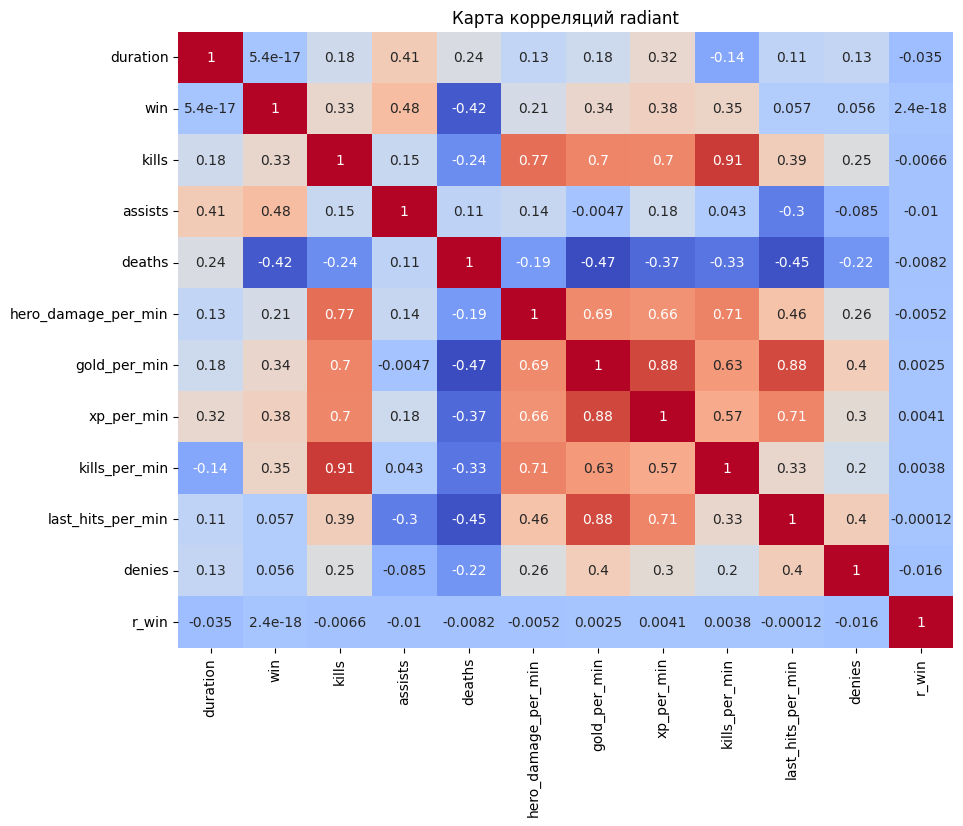

Точечная бисериальная корреляция между числовыми параметрами и победой Radiant:
{'kills': -0.006621565096791639, 'assists': -0.010097859553598442, 'deaths': -0.008232151060547825, 'hero_damage_per_min': -0.0052360778012631466, 'gold_per_min': 0.002489498742357961, 'xp_per_min': 0.004137196293719727, 'kills_per_min': 0.0037776076867275135, 'last_hits_per_min': -0.00012242630661757218, 'denies': -0.015921879616107724}


In [ ]:
# Построение корреляционной матрицы для числовых параметров
correlation_matrix = df_corr.corr()

# Вывод корреляционной матрицы
print(correlation_matrix)

# Построение тепловой карты корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=False)
plt.title("Карта корреляций radiant")
plt.show()

# Проверка точечной бисериальной корреляции между числовыми параметрами и победой Radiant
correlations = {}
for column in ['kills', 'assists', 'deaths', 'hero_damage_per_min', 'gold_per_min', 'xp_per_min', 'kills_per_min', 'last_hits_per_min', 'denies']:
    corr, _ = pointbiserialr(df_corr['r_win'], df_corr[column])
    correlations[column] = corr

# Вывод корреляций
print("Точечная бисериальная корреляция между числовыми параметрами и победой Radiant:")
print(correlations)


### Выводы по Radiant:
  *   Сильная зависимость отсутствует. Ни один из числовых параметров не имеет сильной зависимости с победой Radiant
  *Курсив*
  *   На основе данных корреляционных коэффициентов можно сделать вывод, что ни один из этих числовых параметров не оказывает значительного влияния на вероятность победы команды Radiant. Это может означать, что исход игры зависит от других факторов, возможно, командной работы, стратегии, выбора героев и т. д., а не от индивидуальных числовых параметров.






Построим такую же матрицу для фракции Dire

                         duration           win     kills   assists    deaths  \
duration             1.000000e+00  5.375328e-17  0.183746  0.409208  0.238539   
win                  5.375328e-17  1.000000e+00  0.329204  0.483028 -0.424402   
kills                1.837460e-01  3.292039e-01  1.000000  0.151670 -0.244512   
assists              4.092078e-01  4.830283e-01  0.151670  1.000000  0.108034   
deaths               2.385386e-01 -4.244020e-01 -0.244512  0.108034  1.000000   
hero_damage_per_min  1.312898e-01  2.136281e-01  0.769975  0.144285 -0.190701   
gold_per_min         1.808889e-01  3.385118e-01  0.701092 -0.004687 -0.472358   
xp_per_min           3.229188e-01  3.820276e-01  0.697491  0.180249 -0.374095   
kills_per_min       -1.412173e-01  3.538731e-01  0.911985  0.042841 -0.332774   
last_hits_per_min    1.135070e-01  5.667192e-02  0.391099 -0.304600 -0.452754   
denies               1.326556e-01  5.602437e-02  0.252837 -0.085150 -0.218684   
r_win               -3.48452

<ipython-input-57-17d8040f68a1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['win_dire'] = 1 - df_corr['r_win']


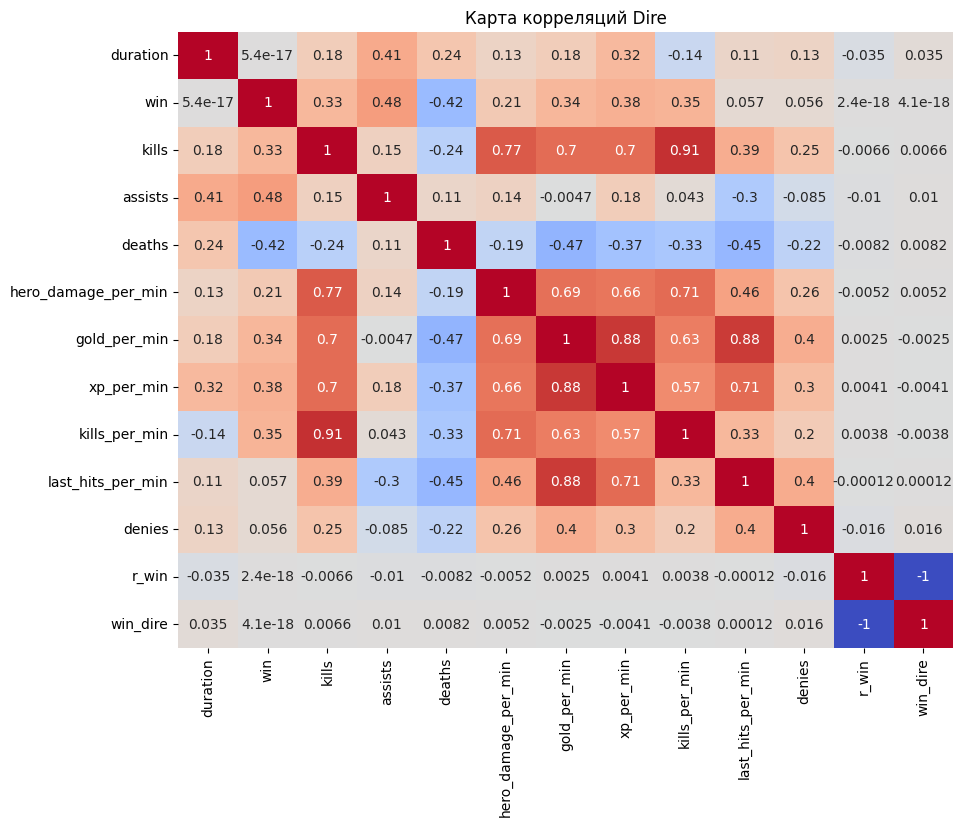

Точечная бисериальная корреляция между числовыми параметрами и победой Dire:
{'kills': -0.32920394645263784, 'assists': -0.48302825318981657, 'deaths': 0.4244020278824025, 'hero_damage_per_min': -0.21362814748154318, 'gold_per_min': -0.3385118313732838, 'xp_per_min': -0.38202755500800595, 'kills_per_min': -0.3538731114834501, 'last_hits_per_min': -0.05667192214690849, 'denies': -0.05602436597174822}


In [ ]:
df_corr['win_dire'] = 1 - df_corr['r_win']
# Построение корреляционной матрицы для числовых параметров
correlation_matrix_dire = df_corr.corr()

# Вывод корреляционной матрицы
print(correlation_matrix_dire)

# Построение тепловой карты корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_dire, annot=True, cmap='coolwarm', cbar=False)
plt.title("Карта корреляций Dire")
plt.show()

# Проверка точечной бисериальной корреляции между числовыми параметрами и победой Dire
correlations = {}
for column in ['kills', 'assists', 'deaths', 'hero_damage_per_min', 'gold_per_min', 'xp_per_min', 'kills_per_min', 'last_hits_per_min', 'denies']:
    corr, _ = pointbiserialr(1 - df_corr['win'], df_corr[column])
    correlations[column] = corr

# Вывод корреляций
print("Точечная бисериальная корреляция между числовыми параметрами и победой Dire:")
print(correlations)

### Выводы по Dire:
  * Подобно результатам для команды Radiant, данные показывают, что числовые параметры, такие как убийства, золото в минуту и опыт в минуту, не оказывают значительного влияния на вероятность победы команды Dire. Это подтверждает, что исход игры, скорее всего, зависит от множества других факторов, которые не отражены в этих числовых показателях



## Построить гистограммы основных параметров матчей (убийства, ассисты, урон в минуту и прочие) в разрезе победивших и проигравших команд и сделать выводы;

In [ ]:
print(df.columns)

Index(['match_id', 'duration', 'first_blood_time', 'r_win', 'personaname',
       'win', 'kills', 'assists', 'deaths', 'hero_id', 'hero_damage_per_min',
       'gold_per_min', 'xp_per_min', 'kills_per_min', 'last_hits_per_min',
       'denies', 'hero'],
      dtype='object')


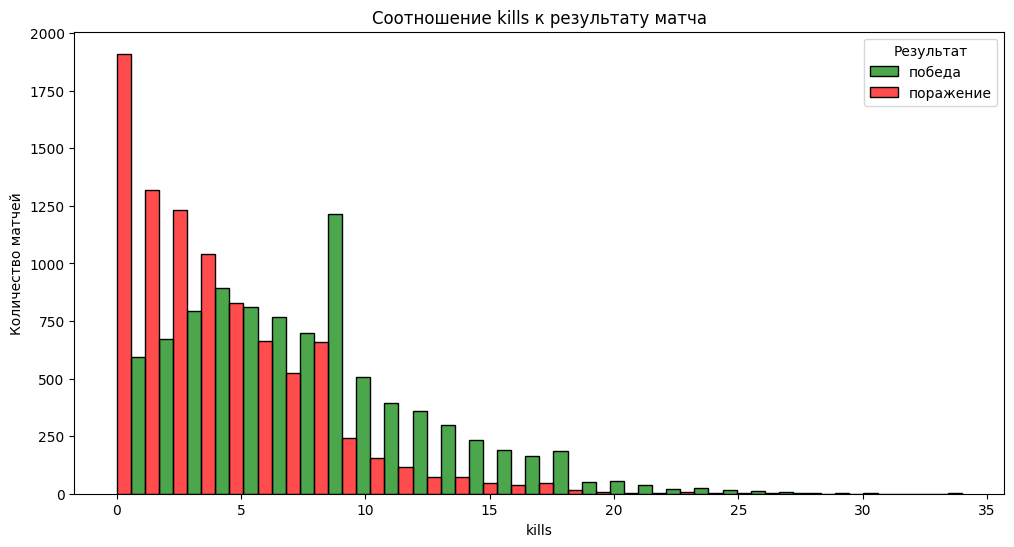

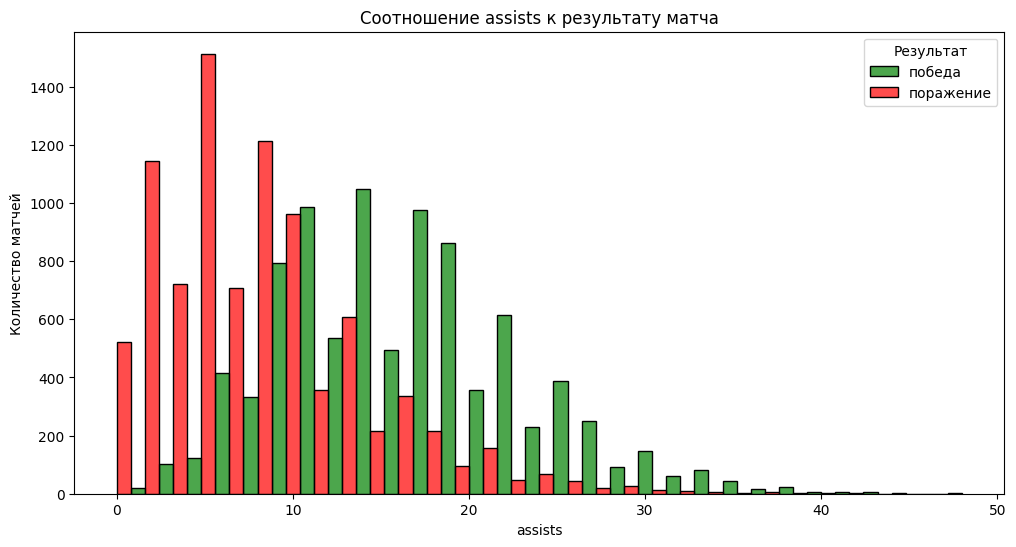

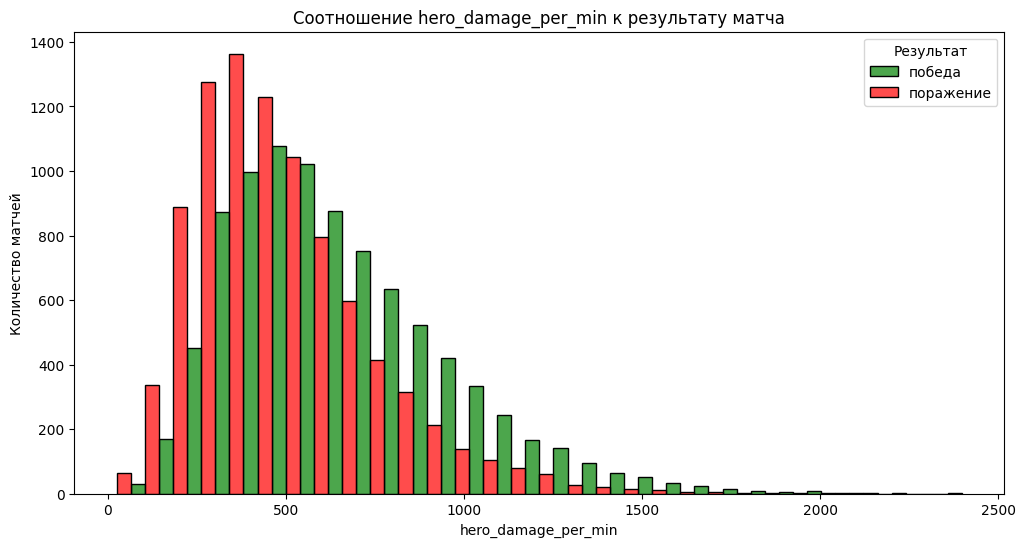

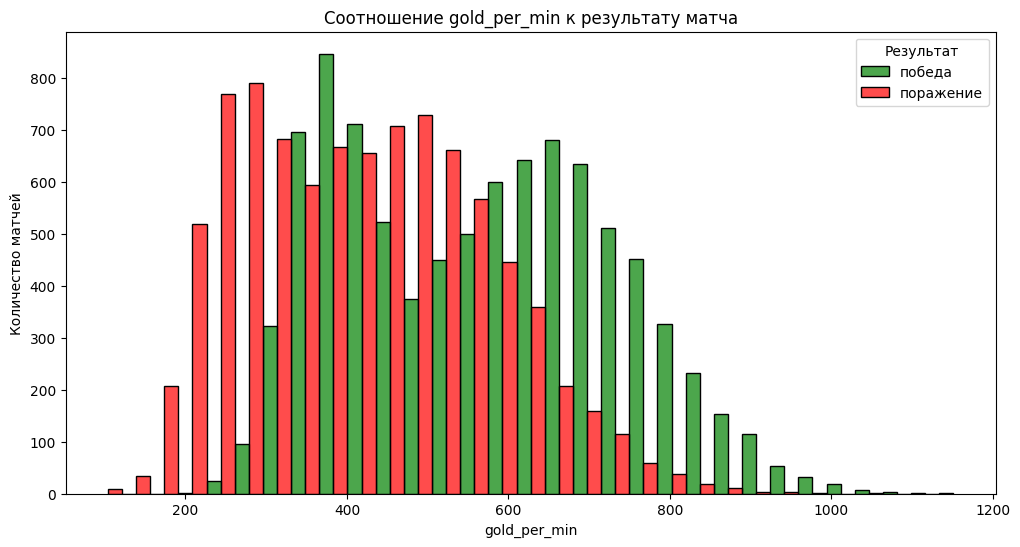

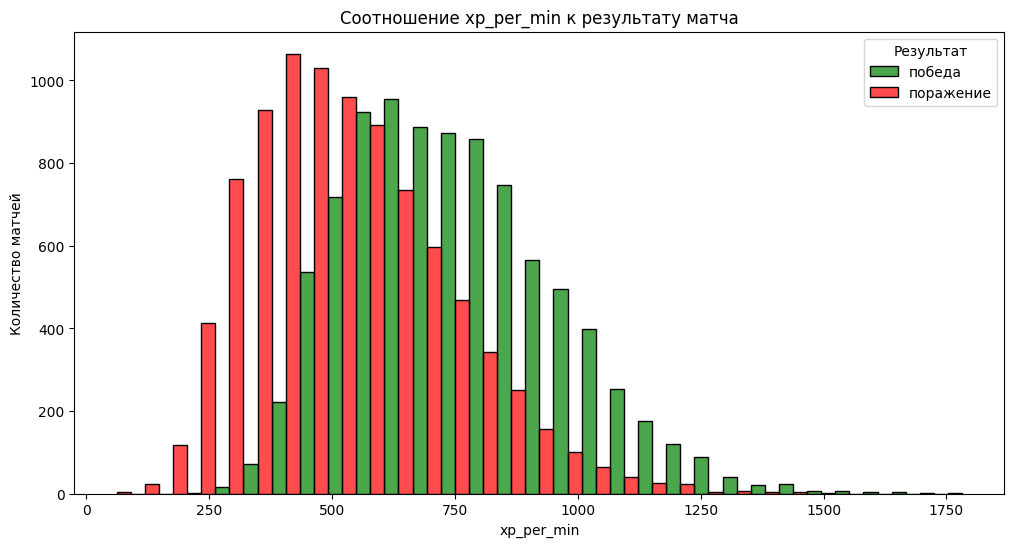

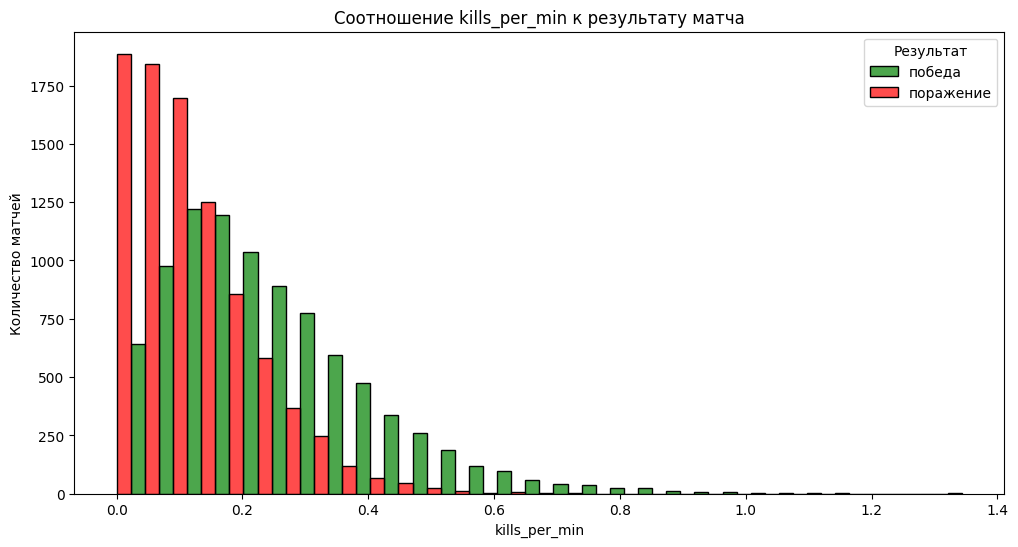

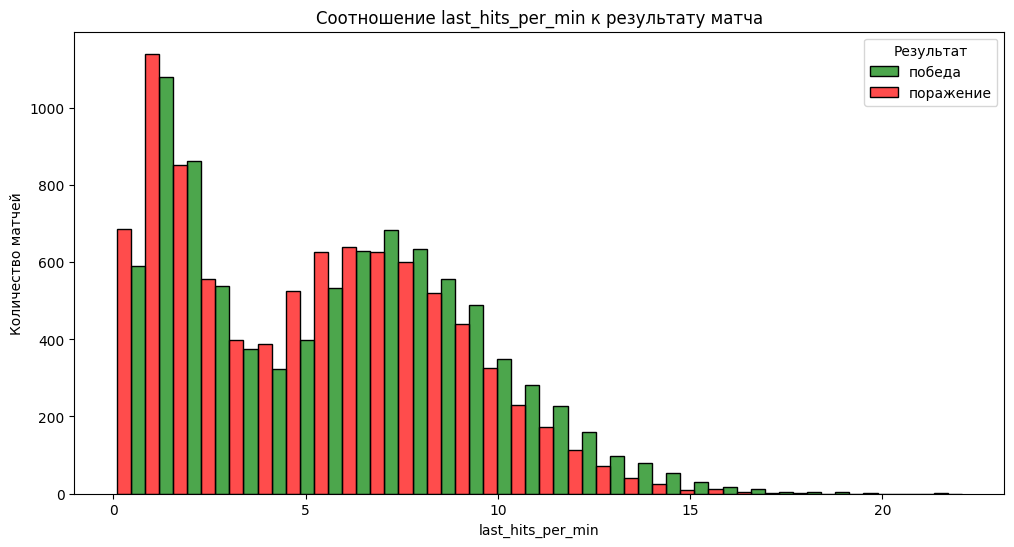

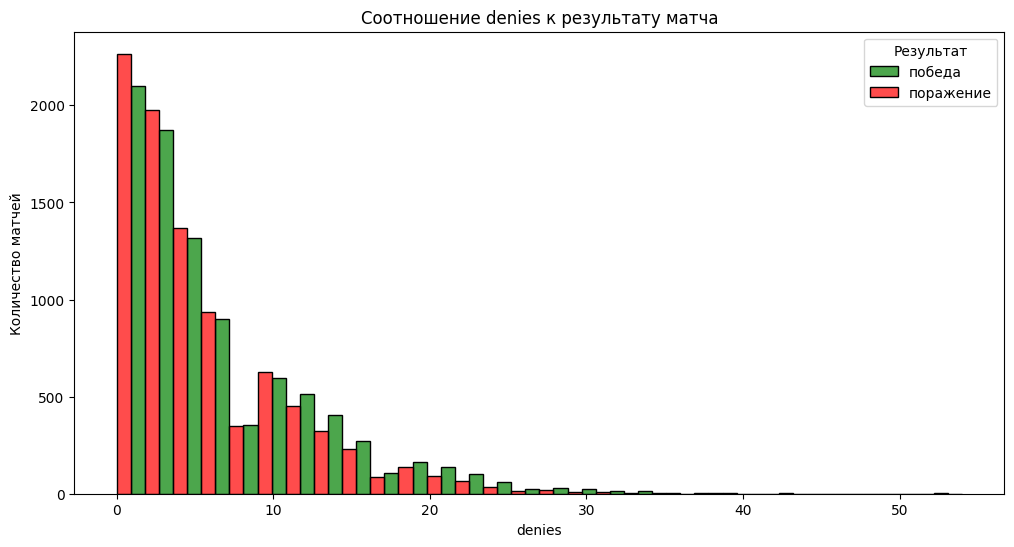

In [ ]:
# Список параметров для гистограмм
parameters = ['kills', 'assists', 'hero_damage_per_min', 'gold_per_min', 'xp_per_min', 'kills_per_min', 'last_hits_per_min', 'denies']

# Построение гистограмм для каждого параметра
for param in parameters:
    plt.figure(figsize=(12, 6))

    # Создание гистограммы с обновлением палитры и легенды
    sns.histplot(data=df,
                 x=param,
                 hue='win',
                 multiple='dodge',
                 palette={1: 'green', 0: 'red'},
                 bins=30,
                 alpha=0.7)

    # Изменение меток в легенде
    plt.legend(title='Результат', labels=['победа', 'поражение'])

    # Добавление заголовка и меток
    plt.title(f'Соотношение {param} к результату матча')
    plt.xlabel(param)
    plt.ylabel('Количество матчей')

    # Показ графика
    plt.show()

### Выводы:
  *   Чем больше убийств совершает команда, тем больше вероятность победы
  *   Чем больше ассистов, тем выше вероятность победы
  *   Чем больше урона в минуту совершают герои, тем выше вероятность победы
  *   Количечтво золота в минуту не всегда влияет на победу.
  *   Количечтво опыта в минуту не всегда влияет на победу.
  *   Количечтво убийств в минуту не всегда влияет на победу.
  *   Количество "добиваний" влияет на победу.
  *   Количество "добиваний своих" влияет на победу.










## Какой герой фармит больше всего золота: по всем матчам, есть ли разница в количестве золота нафармленного героем в разрезе победа / поражение;

In [ ]:
# Шаг 1: Найти героя с максимальным средним значением 'gold_per_min'
average_gold_per_min = df.groupby('hero_id')['gold_per_min'].mean()
max_gold_hero_id = average_gold_per_min.idxmax()

# Шаг 2: Разделить данные на победные и проигрышные матчи для этого героя
wins = df[(df['win'] == 1) & (df['hero_id'] == max_gold_hero_id)]
losses = df[(df['win'] == 0) & (df['hero_id'] == max_gold_hero_id)]

# Шаг 3: Посчитать среднее значение 'gold_per_min' для этого героя в победных и проигрышных матчах
avg_gold_win = wins['gold_per_min'].mean()
avg_gold_loss = losses['gold_per_min'].mean()

# Шаг 4: Вычислить разницу между победами и поражениями
difference = avg_gold_win - avg_gold_loss

# Получить название героя по его 'hero_id'
hero_name = df.loc[df['hero_id'] == max_gold_hero_id, 'hero'].iloc[0]

print(f"Герой с максимальным фармом золота: {hero_name} (Hero ID: {max_gold_hero_id})")
print(f"Среднее золото в минуту при победе: {avg_gold_win:.2f}")
print(f"Среднее золото в минуту при поражении: {avg_gold_loss:.2f}")
print(f"Разница в фарме золота между победой и поражением: {difference:.2f}")

Герой с максимальным фармом золота: Naga Siren (Hero ID: 89)
Среднее золото в минуту при победе: 828.66
Среднее золото в минуту при поражении: 630.10
Разница в фарме золота между победой и поражением: 198.55


## Какие герои получают больше всего опыта за игру;

In [ ]:
# Группируем данные по героям и вычисляем среднее значение опыта за минуту
hero_xp = df.groupby('hero')['xp_per_min'].mean()

# Сортируем по убыванию, чтобы найти героев с наибольшим средним опытом
top_heroes_by_xp = hero_xp.sort_values(ascending=False)

# Выводим топ-героев по опыту
print(top_heroes_by_xp.head(10))  # Показываем топ-10 героев

hero
Lina                895.972477
Anti-Mage           881.479452
Necrophos           878.381818
Sven                875.255474
Luna                868.573009
Ursa                864.471698
Templar Assassin    850.267399
Phantom Assassin    833.915254
Shadow Fiend        832.000000
Troll Warlord       814.776119
Name: xp_per_min, dtype: float64


## Какие фракции чаще побеждают: свет или тьма;


In [ ]:
# Заменяем значения 1 на 'Radiant', а 0 на 'Dire'
df['r_win'] = df['r_win'].replace({1: 'Radiant', 0: 'Dire'})

In [ ]:
value_count_win = df['r_win'].value_counts()
value_count_win

,count
r_win,
Radiant,9140
Dire,8880


Построим график для наглядности

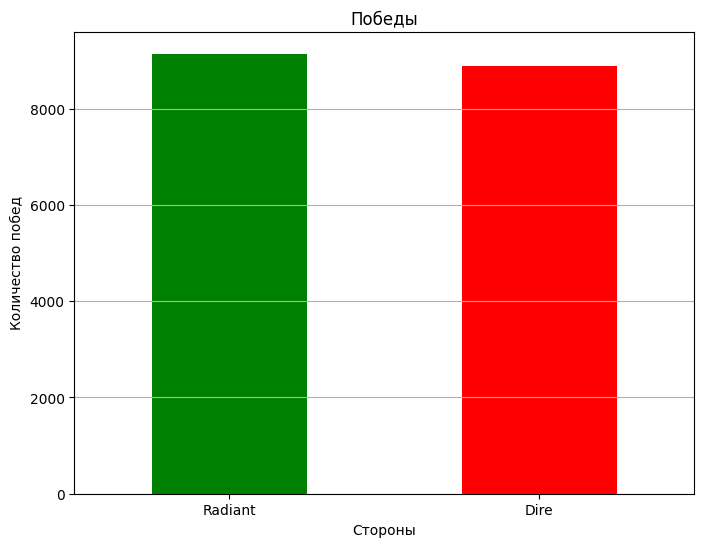

In [ ]:
plt.figure(figsize=(8, 6))
value_count_win.plot(kind='bar', color=['green', 'red'])

plt.title('Победы')
plt.xlabel('Стороны')
plt.ylabel('Количество побед')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

**Вывод** Чаще побеждет светлая сторона (Radiant)



## Среднее время победы каждой фракции


In [ ]:
# Разделяем данные на группы по результату
radi_win = df[df['r_win'] == 'Radiant']['duration']
dire_win = df[df['r_win'] == 'Dire']['duration']

# Считаем среднее время для каждой группы
mean_radi_win_time = radi_win.mean()
mean_dire_win_time = dire_win.mean()

print("Среднее время побед Radiant:", mean_radi_win_time)
print("Среднее время побед Dire:", mean_dire_win_time)

Среднее время побед Radiant: 33.232148067104305
Среднее время побед Dire: 33.8869557057057


## Каких героев чаще всего выбирают;

In [ ]:
# Подсчет количества появлений каждого героя
hero_picks = df['hero'].value_counts()

# Выводим топ-10 самых популярных героев
print(hero_picks.head(10))

hero
Rubick            505
Luna              452
Tiny              432
Crystal Maiden    421
Disruptor         411
Hoodwink          368
Zeus              363
Windranger        355
Gyrocopter        325
Timbersaw         323
Name: count, dtype: int64


## Какие герои чаще всего выигрывают;

In [ ]:
# Отфильтровываем данные для победных матчей
winning_heroes = df[df['win'] == 1]  # Если 1 соответствует победе Radiant, используйте этот фильтр.

# Подсчитываем количество побед для каждого героя
hero_wins = winning_heroes['hero'].value_counts()

# Выводим топ-10 героев с наибольшим числом побед
print(hero_wins.head(10))

hero
Rubick            249
Luna              225
Crystal Maiden    217
Disruptor         211
Tiny              206
Hoodwink          204
Zeus              187
Windranger        185
Gyrocopter        165
Morphling         159
Name: count, dtype: int64


## Какие герои совершают больше всего убийств, ассистов;

In [ ]:
# Подсчет общего количества убийств для каждого героя
hero_kills = df.groupby('hero')['kills'].sum().sort_values(ascending=False)

# Подсчет общего количества ассистов для каждого героя
hero_assists = df.groupby('hero')['assists'].sum().sort_values(ascending=False)

# Выводим топ-10 героев по количеству убийств
print("Герои с наибольшим количеством убийств:")
print(hero_kills.head(10))

# Выводим топ-10 героев по количеству ассистов
print("\nГерои с наибольшим количеством ассистов:")
print(hero_assists.head(10))

Герои с наибольшим количеством убийств:
hero
Zeus                3163
Windranger          2855
Luna                2842
Timbersaw           2684
Morphling           2608
Tiny                2144
Lifestealer         2140
Templar Assassin    2134
Hoodwink            2053
Rubick              2011
Name: kills, dtype: int64

Герои с наибольшим количеством ассистов:
hero
Disruptor            7680
Rubick               7512
Crystal Maiden       5749
Tiny                 5681
Hoodwink             5343
Zeus                 4787
Centaur Warrunner    4194
Windranger           4119
Shadow Demon         4105
Vengeful Spirit      3733
Name: assists, dtype: int64


## Какой герой меньше всего умирает;

In [ ]:
# Подсчет общего количества смертей для каждого героя
hero_deaths = df.groupby('hero')['deaths'].sum().sort_values()

# Выводим героя с наименьшим количеством смертей
print("Герой с наименьшим количеством смертей:")
print(hero_deaths.head(1))

Герой с наименьшим количеством смертей:
hero
Phantom Lancer    102
Name: deaths, dtype: int64


## Cреднее время до первой крови + гистограмма;

Среднее время до первой крови: 2.10 минут


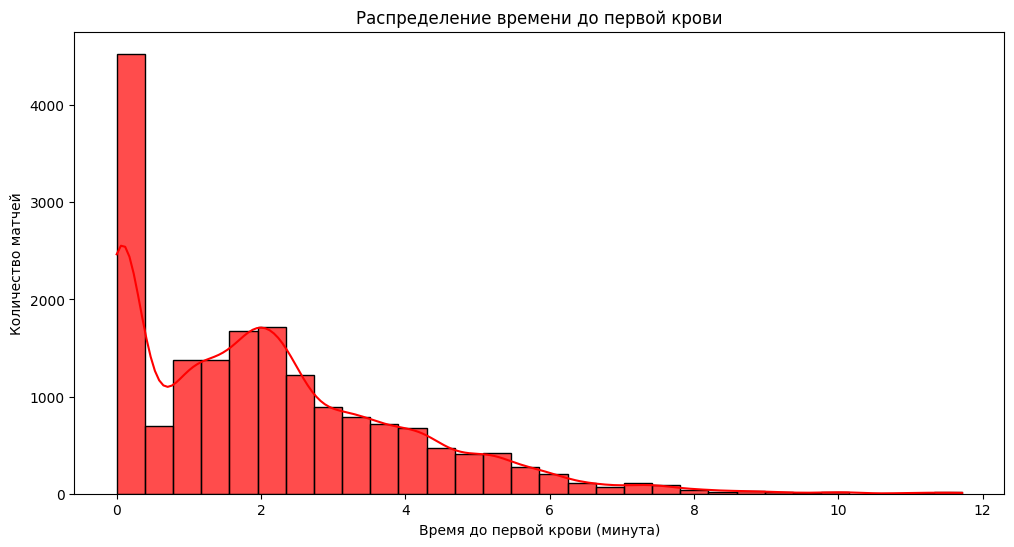

In [ ]:
# Расчет среднего времени до первой крови
average_first_blood_time = df['first_blood_time'].mean()
print(f'Среднее время до первой крови: {average_first_blood_time:.2f} минут')

# Построение гистограммы времени до первой крови
plt.figure(figsize=(12, 6))
sns.histplot(df['first_blood_time'], bins=30, kde=True, color='red', alpha=0.7)

# Добавление заголовка и меток
plt.title('Распределение времени до первой крови')
plt.xlabel('Время до первой крови (минута)')
plt.ylabel('Количество матчей')

# Показ гистограммы
plt.show()

# Аналитическая часть:

## Гипотеза 1: Самое частое время победы одной стороны отличается от самого частого времени победы другой стороны?

Самое частое время побед Radiant: 21.466666666666665
Самое частое время побед Dire: 27.616666666666667


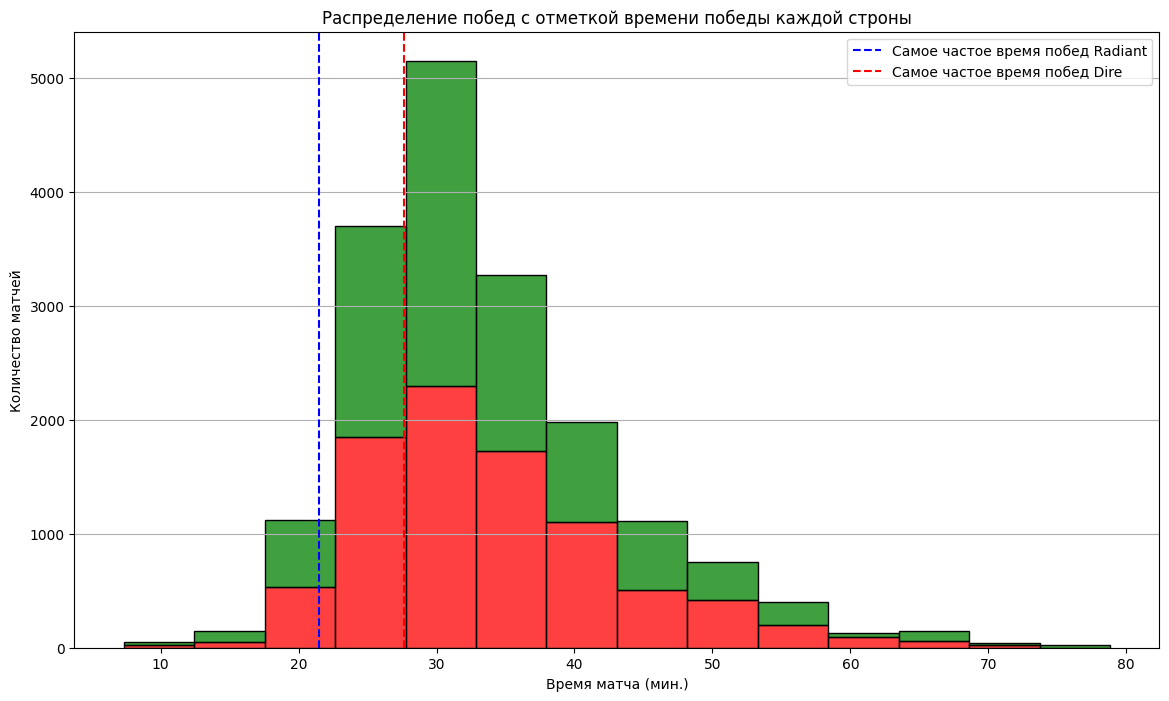

In [ ]:
# Найдем самое популярное время побед для каждой стороны
most_common_radiant_win = df[df['r_win'] == 'Radiant']['duration'].mode()[0]
most_common_dire_win = df[df['r_win'] == 'Dire']['duration'].mode()[0]

print(f"Самое частое время побед Radiant: {most_common_radiant_win}")
print(f"Самое частое время побед Dire: {most_common_dire_win}")

# Построим график и сравним визуально
plt.figure(figsize=(14, 8))
sns.histplot(df, x='duration', hue='r_win', multiple='stack', bins=14, palette={'Radiant': 'green', 'Dire': 'red'})
plt.axvline(most_common_radiant_win, color='blue', linestyle='--', label='Самое частое время побед Radiant')
plt.axvline(most_common_dire_win, color='red', linestyle='--', label='Самое частое время побед Dire')

plt.title('Распределение побед с отметкой времени победы каждой строны')
plt.xlabel('Время матча (мин.)')
plt.ylabel('Количество матчей')
plt.legend()
plt.grid(axis='y')
plt.show()

## Гипотеза 2: Помогает ли первая кровь победить?
 - Нулевая гипотеза (H₀): Первая кровь не оказывает влияния на исход матча. Процент побед в матчах с первой кровью не отличается от процента побед в матчах без первой крови.

 - Альтернативная гипотеза (H₁): Первая кровь оказывает положительное влияние на исход матча. Процент побед в матчах с первой кровью выше, чем в матчах без первой крови.



In [ ]:
# Подсчет количества побед и общего количества матчей для первой крови
fb_wins = df[df['first_blood_time'] <= df['duration']]['win'].sum()  # Победы после первой крови
fb_total = df[df['first_blood_time'] <= df['duration']].shape[0]     # Всего матчей с первой кровью

# Подсчет количества побед и общего количества матчей для без первой крови
no_fb_wins = df[df['first_blood_time'] > df['duration']]['win'].sum()  # Победы без первой крови
no_fb_total = df[df['first_blood_time'] > df['duration']].shape[0]     # Всего матчей без первой крови

# Объединяем количество побед и общее количество матчей
successes = [fb_wins, no_fb_wins]
totals = [fb_total, no_fb_total]

# Проводим Z-тест для сравнения пропорций
z_stat, p_value = proportions_ztest(successes, totals)

# Выводим результаты
print(f"Z-статистика: {z_stat:.2f}, p-значение: {p_value:.4f}")

# Интерпретация p-value
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу. Первая кровь влияет на победу.")
else:
    print("Не отвергаем нулевую гипотезу. Первая кровь не оказывает значительного влияния на победу.")



Z-статистика: nan, p-значение: nan
Не отвергаем нулевую гипотезу. Первая кровь не оказывает значительного влияния на победу.


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/proportion.py:1004: RuntimeWarning: invalid value encountered in divide
  prop = count * 1. / nobs
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/proportion.py:1020: RuntimeWarning: divide by zero encountered in divide
  nobs_fact = np.sum(1. / nobs)


# Итоговые выводы
*   Корреляция между основными числовыми параметрами и победой фрацкии отсутствует. Влияния на победу нет.
*   Чем больше убийств совершает команда, тем больше вероятность победы
*   Чем больше ассистов, тем выше вероятность победы
*   Чем больше урона в минуту совершают герои, тем выше вероятность победы
*   Количечтво золота в минуту не всегда влияет на победу.
*   Количечтво опыта в минуту не всегда влияет на победу.
*   Количечтво убийств в минуту не всегда влияет на победу.
*   Количество "добиваний" влияет на победу.
*   Количество "добиваний своих" влияет на победу.
*   Герой с максимальным фармом золота: Naga Siren (Hero ID: 89).
*   Больше всего опыта за игру получают Lina, Antimage и Necrophos.
*   Фракция Radiant побеждает немного чаще, чем Dire.
*   Среднее время победы обеих фракций практичести одинаково -  33 минуты.
*   Radiant чаще всего выигрывают на 22 минуте, Dire на 27 минуте.
*   Чаще всего выбирают таких героев: Rubick, Luna и Tiny.
*   Чаще всего выигрывают: Rubick, Lina и Crystal Maiden.
*   Больше всех убийств совершает Zeus, больше всех ассистов у Disruptor.
*   Меньше всех умирает Phantom Lancer.
*   Среднее время до первой крови - 2 минуты.


*   Лучше играть более агресивно и стараться закончить игру до 30й минуты матча, тогда верятность победы будет выше.
*   Первая кровь не способствует победе в матче.





